In [1]:
import tensorflow as tf
from tensorflow import keras as keras
print(tf.__version__)

print(keras.__version__)

2.3.1
2.4.0


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.callbacks import History

# Transfer learning

<br>

<img src="Grafika/transfer_learning.png" width="550">

**Transfer learning** (transfer "wiedzy") - wykorzystanie nauczonych przez kogoś sieci do naszego problemu. Możliwe dzięki temu, że cechy wykrywane przez sieci w głębokich warstwach mogą być uniwersalne i przydatne w różnych problemach.

### VGG16

In [3]:
from tensorflow.keras.applications import VGG16, InceptionV3
base_model = VGG16(weights='imagenet',include_top=False)
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

### InceptionV3

In [4]:
inc = InceptionV3()
inc.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

# Zad
Trzeba nadać wymiar wejści anaszej sieci
```python
h,w = 150, 150
```

In [5]:
h,w = 150, 150
model = VGG16(weights='imagenet',include_top=False,input_shape=(h,w,3))

In [6]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [7]:
len(model.layers)

19

# Zad 
Zbudujmy siec z 
* VGG16 dla wejścia h,w = 150, 150
* Flatten
* Dense
* Dense

In [8]:
h,w = 150, 150
model = VGG16(weights='imagenet',include_top=False,input_shape=(h,w,3))

top_model = Sequential()
top_model.add(Flatten(input_shape=model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dense(1, activation='sigmoid'))

model_transfer = Sequential()
model_transfer.add(model)
model_transfer.add(top_model)

model_transfer.layers[0].trainable = False

model_transfer.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
sequential (Sequential)      (None, 1)                 2097665   
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


In [9]:
# model.summary()
# top_model.summary()

# Zad
Naucz model na danych z 

https://www.microsoft.com/en-us/download/details.aspx?id=54765
 
* użyj Image Augmentation

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

model_transfer.compile(loss='binary_crossentropy',optimizer="sgd",metrics=['accuracy'])

train_data_dir = r'C:\j_python\bootcamp_deep_learning\Dane\data\train'
validation_data_dir = r'C:\j_python\bootcamp_deep_learning\Dane\data\validation'
nb_validation_samples = 200
nb_train_samples = 50
epochs = 50
batch_size = 10

# prepare data augmentation configuration
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   shear_range=0.2, 
                                   zoom_range=0.2,
                                   rotation_range=45, 
                                   horizontal_flip=True)


test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_data_dir, 
                                                    target_size=(h, w), 
                                                    batch_size=batch_size, 
                                                    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(validation_data_dir,
                                                        target_size=(h, w), 
                                                        batch_size=batch_size,
                                                        class_mode='binary')


Found 200 images belonging to 2 classes.
Found 10 images belonging to 2 classes.


In [11]:
nb_validation_samples//batch_size

20

In [37]:
history_tr_ag = History()
early_stopping = EarlyStopping(patience=3,monitor="val_loss")
# model_transfer.fit_generator(train_generator, samples_per_epoch=batch_size, epochs=epochs, 
#                     validation_data=validation_generator, nb_val_samples=10, callbacks=[early_stopping, history_tr_ag])

model_transfer.fit(train_generator, batch_size=batch_size, epochs=epochs, 
                    validation_data=validation_generator,  callbacks=[early_stopping, history_tr_ag])

Epoch 1/50
20/20 [==============================] - 14s 714ms/step - loss: 1.0754 - accuracy: 0.4900 - val_loss: 0.6477 - val_accuracy: 0.8000
Epoch 2/50
20/20 [==============================] - 15s 730ms/step - loss: 0.6438 - accuracy: 0.6550 - val_loss: 0.6744 - val_accuracy: 0.5000
Epoch 3/50
20/20 [==============================] - 15s 749ms/step - loss: 0.6705 - accuracy: 0.5850 - val_loss: 0.5707 - val_accuracy: 0.8000
Epoch 4/50
20/20 [==============================] - 15s 734ms/step - loss: 0.5867 - accuracy: 0.6900 - val_loss: 0.5854 - val_accuracy: 0.5000
Epoch 5/50
20/20 [==============================] - 15s 733ms/step - loss: 0.5588 - accuracy: 0.7650 - val_loss: 0.4723 - val_accuracy: 0.9000
Epoch 6/50
20/20 [==============================] - 15s 735ms/step - loss: 0.4872 - accuracy: 0.7300 - val_loss: 0.5249 - val_accuracy: 0.7000
Epoch 7/50
20/20 [==============================] - 15s 767ms/step - loss: 0.5830 - accuracy: 0.6850 - val_loss: 0.4272 - val_accuracy: 0.9000

In [39]:
model_transfer.evaluate(validation_generator)

1/1 [==============================] - 0s 1ms/step - loss: 0.5122 - accuracy: 0.5000


[0.5121737718582153, 0.5]

In [40]:
# # model.evaluate(X_test,y_test)
# history_tr = History()
# early_stopping = EarlyStopping(patience=3,monitor="val_loss")
# model_transfer.compile(loss="categorical_crossentropy",optimizer="adam",metrics=["accuracy"])
# model_transfer.fit(X_train, y_train, validation_split=0.25,epochs=100,callbacks=[early_stopping, history_tr])
# model_transfer.evaluate(X_test,y_test)

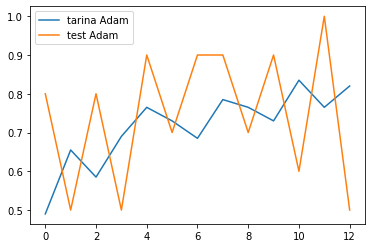

In [41]:
plt.plot(history_tr_ag.history['accuracy'], label = "tarina Adam")
plt.plot(history_tr_ag.history['val_accuracy'], label = "test Adam")


plt.legend()
plt.show()

In [84]:
test_data_dir = r'C:\j_python\bootcamp_deep_learning\Dane\data\test'
test_generator = test_datagen.flow_from_directory(test_data_dir,
                                                        target_size=(h, w), 
                                                        batch_size=batch_size,
                                                        class_mode='binary')

Found 4 images belonging to 2 classes.


In [85]:
model_transfer.predict(test_generator)

array([[0.9755111 ],
       [0.42210972],
       [0.09309158],
       [0.9878304 ]], dtype=float32)

In [86]:
# model_transfer.predict_classes(test_generator)
pr = model_transfer.predict(test_generator)
pr

array([[0.9878304 ],
       [0.42210972],
       [0.09309158],
       [0.9755111 ]], dtype=float32)

DOG


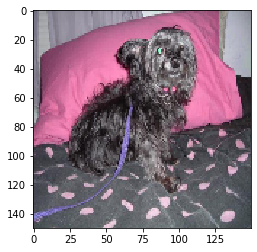

CAT


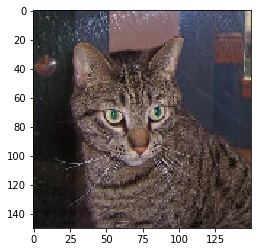

CAT


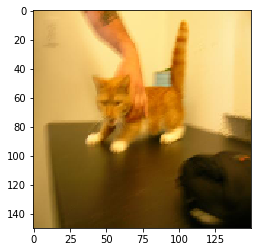

DOG


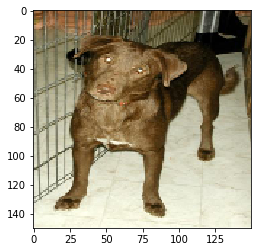

In [87]:
for i in np.arange(4):
#     print(pr[i][0])
    if pr[i][0] > 0.5:
        print("DOG")
    else:   
        print("CAT")
    plt.imshow(test_generator[0][0][i])
    plt.show()
